# DES Simulation

This notebook generates the results used in the report for the second assignment of the course 'Stochastic Simulation'.

Authors:

1. Divyaben Hasmukhbhai Gajera
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: divya.gajera@student.uva.nl
- Student Number: 14932644

2. K. López
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: kenia.lopez.sotomayor@student.uva.nl
- Student Number: 12965081

3. T. P. Glansdorp
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: thomas.glansdorp@student.uva.nl
- Student Number: 12748587

## DES program that implements FIFO scheduling case

In [2]:
import simpy as sm
import random
import pandas as pd
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt

In [129]:
class g:
    number_of_servers = 1
    arrival_rate = 1/number_of_servers
    service_rate = 2
    sim_duration = 500
    number_of_runs = 10

class Customer:
    def __init__(self, customer_id):
        self.id = customer_id
        self.queue_time = 0

class Queue:
    
    def __init__(self, run_number, queue_type):
        self.env = sm.Environment()
        self.server = sm.Resource(self.env, capacity=g.number_of_servers)
        self.run_number = run_number
        self.queue_type = queue_type
        self.customer_counter = 0
        self.mean_queue_time = 0
        self.mean_system_time = 0
        self.mean_service_time = 0
        #self.file_name = file_name
        columns = ["Customer ID", "Start Queueing", "End Queueing", "Queueing Time", "Sojourn Time", "Service Time"] 
        self.results_df = pd.DataFrame(columns=columns)
        self.results_df.set_index("Customer ID", inplace=True)
        self.arrival_times = []
        self.departure_times = []
        self.queue_empty_duration = 0
        
    
    # Method that generates customers arrivals
    def generate_arrivals(self):
        while True:
            self.customer_counter += 1
            cp = Customer(self.customer_counter)
            # Run activity generator for this customer
            self.env.process(self.create_queue(cp))

            # sample time until next customer
            t = random.expovariate(g.arrival_rate)

            # Freeze untill that time has passed
            yield self.env.timeout(t)
            
    def create_queue(self, customer):
        start_queue = self.env.now
        self.arrival_times.append(self.env.now)
        
        # Request a server
        with self.server.request() as req:
            # Freeze until the request can be met 
            yield req
            
            # Sample time spent in server
            if self.queue_type == "MMn":
                sampled_service_time = random.expovariate(g.service_rate)
            elif self.queue_type == "MDn":
                sampled_service_time = 3.6
            elif self.queue_type == "MLn":
                    rand = random.random()
                    if rand <= 0.75:
                        sampled_service_time = random.expovariate(1.0)
                    else:
                        sampled_service_time = random.expovariate(5.0)
            
            end_queue = self.env.now
            
            # Freeze until that time has passed
            yield self.env.timeout(sampled_service_time)
            self.departure_times.append(self.env.now)
            
            # Calculate time customer was queueing
            out_of_system = self.env.now
            sojourn_time = out_of_system - start_queue
            customer.queue_time = end_queue - start_queue
            df_to_add = pd.DataFrame({"Customer ID":[customer.id], "Start Queueing": [start_queue],
                                     "End Queueing": [end_queue], "Queueing Time": [customer.queue_time],
                                     "Sojourn Time": [sojourn_time], "Service Time":[sampled_service_time]})
            df_to_add.set_index("Customer ID", inplace=True)
            self.results_df = pd.concat([self.results_df, df_to_add])
            
    def calculate_mean_times(self):
        self.mean_queue_time = self.results_df["Queueing Time"].mean()
        self.mean_system_time = self.results_df["Sojourn Time"].mean()
        self.mean_service_time = self.results_df["Service Time"].mean()
        
    def write_run_results(self):
        with open(self.file_name, "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [self.run_number, self.mean_queue_time]
            writer.writerow(results_to_write)
            
    def run(self):
        self.env.process(self.generate_arrivals())
        self.env.run(until=g.sim_duration)
        # Calculate run results
        self.calculate_mean_times()
        #self.write_run_results()
        

In [36]:
def calculate_CI(data):
    
    sigma = data.std()
    x_bar = data.mean()
    CI = (x_bar - (1.96*sigma/np.sqrt(data.shape[0])), x_bar + (1.96*sigma/np.sqrt(data.shape[0])))
    
    return CI

In [40]:
def estimate_waiting_times(type_queue, RHO, MU, n):
    
    mean_queue = []
    mean_sojourn = []
    mean_service = []
    for rho in RHO:
        temp_mean_queue_run = []
        temp_sj = []
        temp_serice = []
        g.arrival_rate = MU*rho
        g.service_rate = MU
        g.number_of_servers = n
        g.number_of_runs = 100
        for run in range(g.number_of_runs):
            queue_model = Queue(run, type_queue)
            queue_model.run()
            temp_mean_queue_run.append(queue_model.mean_queue_time)
            temp_sj.append(queue_model.mean_system_time)
            temp_serice.append(queue_model.mean_service_time)
        mean_queue.append(np.array(temp_mean_queue_run).mean(axis=0))
        mean_sojourn.append(np.array(temp_sj).mean(axis = 0))
        mean_service.append(np.array(temp_serice).mean(axis=0))
    
    return mean_queue, mean_sojourn, mean_service

In [41]:
MU = 4
RHO = [0.1, 0.2,0.3, 0.4, 0.45, 0.45, 0.55, 0.6, 0.65, 0.7, 0.725, 0.75, 0.8,0.825, 0.85, 0.9, 0.925,0.95, 0.975,1.0, 1.1,1.2]
num_sim = [5, 10, 25, 50, 100, 150, 500, 1000]

In [46]:
est_mean, est_sojourn, est_service = estimate_waiting_times("MMn", RHO, MU, 1)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\thoma\AppData\Local\Temp\ipykernel_16836\1415594810.py", line 78, in create_queue
    df_to_add = pd.DataFrame({"Customer ID":[customer.id], "Start Queueing": [start_queue],
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py", line 736, in __init__
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\internals\construction.py", line 503, in dict_to_mgr
    return arrays_to_mgr(arrays, columns, index, dtype=dtype, typ=typ, consolidate=copy)
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\internals\construction.py", line 152, in arrays_to_mgr
    return create_block_manager_from_column_arrays(
  File "C:\User

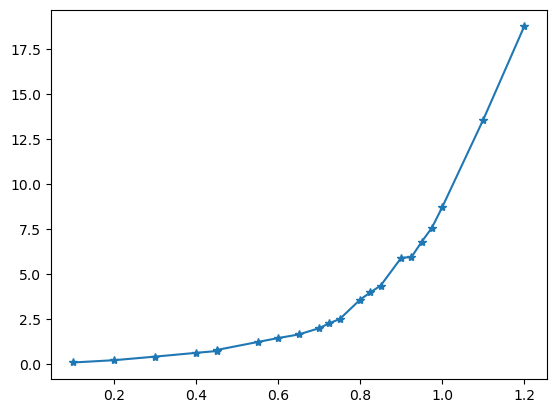

In [ ]:
plt.plot(RHO, np.array(est_mean), "*-")

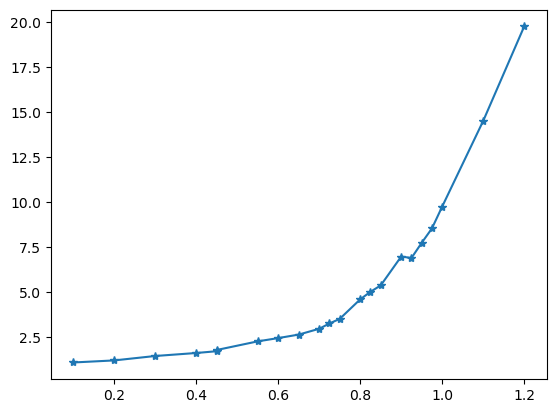

In [ ]:
plt.plot(RHO, np.array(est_sojourn), "*-")

In [ ]:
est_mean_2, est_sojourn_2, est_service_2 = estimate_waiting_times("MMn", RHO, MU, 2)
    

In [ ]:
est_mean_4, est_sojourn_4, est_service_4 = estimate_waiting_times("MMn", RHO, MU, 4)

Text(0, 0.5, 'Avg Waiting Time')

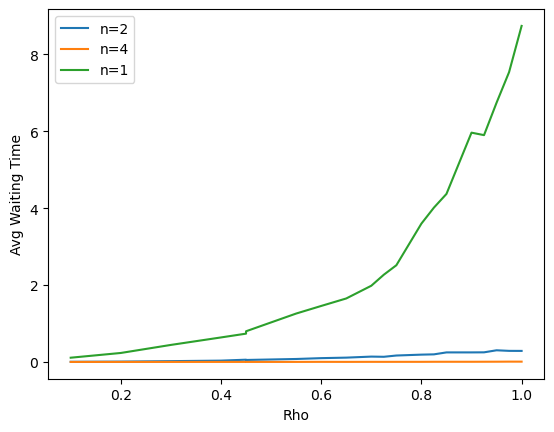

In [ ]:
plt.plot(RHO[:-2], est_mean_2[:-2], label="n=2")
plt.plot(RHO[:-2], est_mean_4[:-2], label="n=4")
plt.plot(RHO[:-2], est_mean[:-2], label="n=1")
plt.legend()
plt.xlabel("Rho")
plt.ylabel("Avg Waiting Time")

## Customer Distribution analysis

In [119]:
TIME_STEPS = np.linspace(0, 500, num=500) #[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200]

In [120]:
def customer_distribution(type_queue, n, total_time, MU):
    customer_distribution = []
    g.number_of_servers = n
    g.number_of_runs = 200
    g.arrival_rate = MU*0.9
    g.service_rate = MU
    for run in range(g.number_of_runs):
        queue_model = Queue(run, type_queue)
        queue_model.run()
        arrival_times_run = np.array(queue_model.arrival_times)
        departure_times_run = np.array(queue_model.departure_times)
        temp_customer_distribution = []
        unoccupied_queue_list = []
        temp_customer_time_step = 0
        customer_distribution = 0
        unoccupied_queue = 0
        for t_step in range(len(total_time) - 1):
            arrivals_time_step = ((total_time[t_step] <= arrival_times_run) & (arrival_times_run <= total_time[t_step + 1])).sum()
            #print(arrivals_time_step)
            departures_time_step = ((total_time[t_step] <= departure_times_run) & (departure_times_run <= total_time[t_step + 1])).sum()
            #print(departures_time_step)
            customers_time_step = temp_customer_time_step + (arrivals_time_step - departures_time_step)
            temp_customer_time_step = customers_time_step
            temp_customer_distribution.append(customers_time_step)
            if customers_time_step == 0:
                unoccupied_queue += 1
            #print(temp_customer_distribution)
        customer_distribution += np.array(temp_customer_distribution)
        unoccupied_queue_list.append(unoccupied_queue)
        #print(customer_distribution)

    avg_customer_distribution = customer_distribution / g.number_of_runs
    unoccupied_queue_mean = sum(unoccupied_queue_list)/ len(unoccupied_queue_list)
    print(unoccupied_queue_mean)
    occupied_mean = ((500 - (unoccupied_queue_mean)) /500) * 100
    print(occupied_mean)
    #print(avg_customer_distribution)
    cd = avg_customer_distribution.tolist()
    cd.insert(0,0)
    return cd, occupied_mean
            

In [121]:
cd_1_MMn, occupied_rate_1 = customer_distribution("MMn", 1, TIME_STEPS, MU)
cd_2_MMn, occupied_rate_2 = customer_distribution("MMn", 2, TIME_STEPS, MU)
cd_4_MMn, occupied_rate_4 = customer_distribution("MMn", 4, TIME_STEPS, MU)

46.0
90.8
189.0
62.2
205.0
59.0


90.8


Text(0, 0.5, 'Average number of customers')

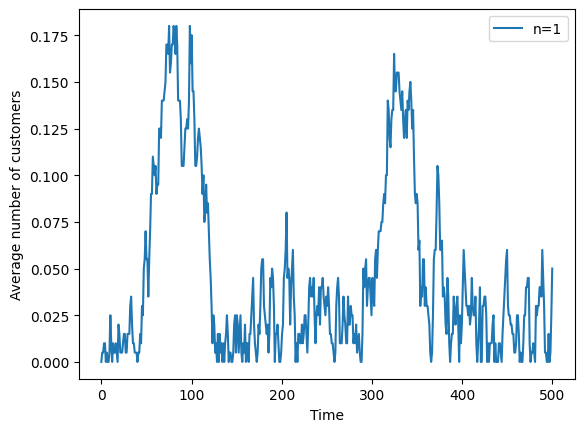

In [122]:
print(occupied_rate_1)
plt.plot(TIME_STEPS, cd_1_MMn, label="n=1")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")

62.2


Text(0, 0.5, 'Average number of customers')

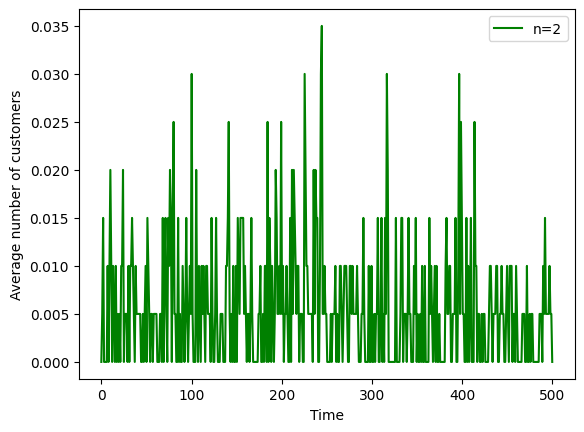

In [123]:
print(occupied_rate_2)
plt.plot(TIME_STEPS, cd_2_MMn, label="n=2", color="green")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")

59.0


Text(0, 0.5, 'Average number of customers')

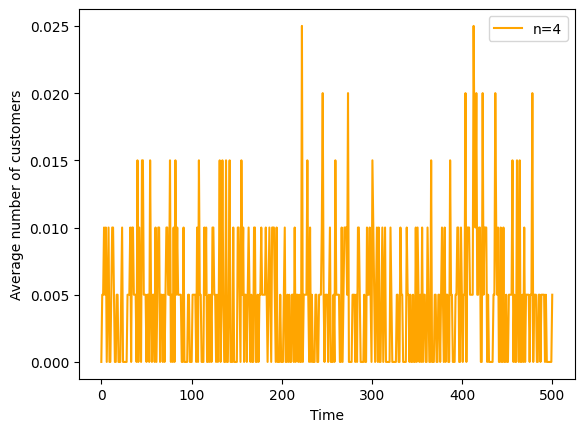

In [124]:
print(occupied_rate_4)
plt.plot(TIME_STEPS, cd_4_MMn, label="n=4", color="orange")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")

In [130]:
cd_1_MDn, occupied_rate_1_MDn = customer_distribution("MDn", 1, TIME_STEPS, MU)
cd_2_MDn, occupied_rate_2_MDn = customer_distribution("MDn", 2, TIME_STEPS, MU)
cd_4_MDn, occupied_rate_4_MDn = customer_distribution("MDn", 4, TIME_STEPS, MU)

0.0
100.0
0.0
100.0
0.0
100.0


100.0


Text(0, 0.5, 'Amount of customers in system')

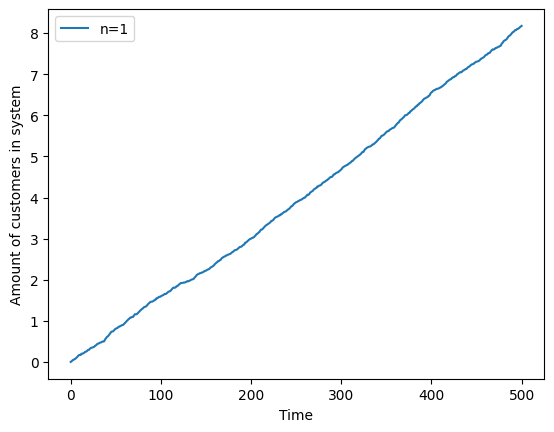

In [131]:
print(occupied_rate_1_MDn)
plt.plot(TIME_STEPS, cd_1_MDn, label="n=1")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amount of customers in system")

100.0


Text(0, 0.5, 'Amount of customers in system')

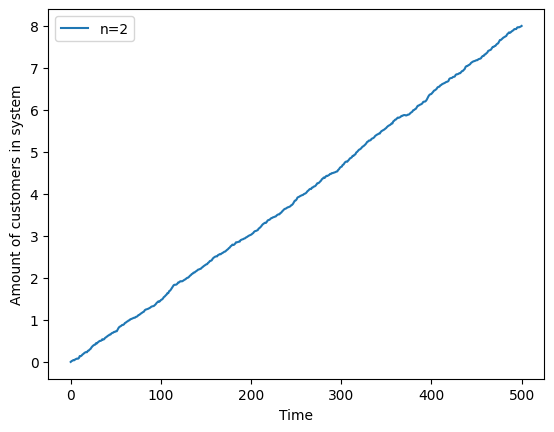

In [132]:
print(occupied_rate_2_MDn)
plt.plot(TIME_STEPS, cd_2_MDn, label="n=2")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amount of customers in system")

100.0


Text(0, 0.5, 'Amount of customers in system')

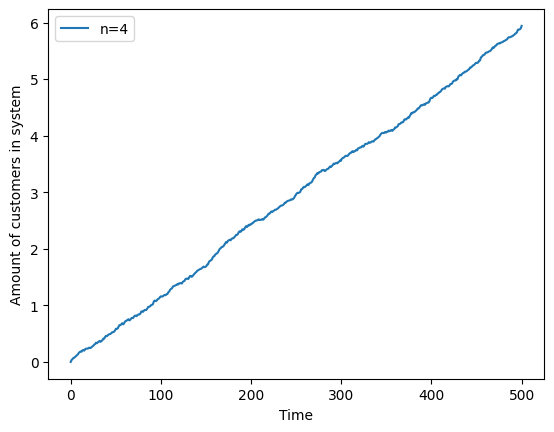

In [133]:
print(occupied_rate_4_MDn)
plt.plot(TIME_STEPS, cd_4_MDn, label="n=4")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amount of customers in system")

In [136]:
cd_1_MLn, occupied_rate_1_MLn = customer_distribution("MLn", 1, TIME_STEPS, MU)
#cd_2_MLn = customer_distribution("MLn", 2, TIME_STEPS, MU)
#cd_4_MLn = customer_distribution("MLn", 4, TIME_STEPS, MU)

0.0
100.0


100.0


Text(0, 0.5, 'Amount of customers in system')

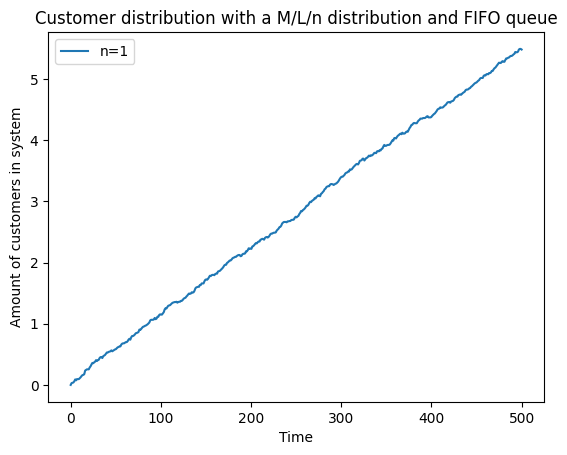

In [137]:
print(occupied_rate_1_MLn)
plt.plot(TIME_STEPS, cd_1_MLn, label="n=1")
#plt.plot(TIME_STEPS, cd_2_MLn, label="n=2")
#plt.plot(TIME_STEPS, cd_4_MLn, label="n=4")
plt.legend()
plt.title("Customer distribution with a M/L/n distribution and FIFO queue")
plt.xlabel("Time")
plt.ylabel("Amount of customers in system")

## Ocupation rate


### Statistical significance 

### Numer of measurements required

## DES program that implements shortest job first case for M/M/1

In [5]:
class SJF_queue:
    
    def __init__(self, run_number):
        self.env = sm.Environment()
        self.customer_counter = 0
        self.server = sm.PriorityResource(self.env, capacity=g.number_of_servers)
        self.run_number = run_number
        self.mean_queue_time = 0
        self.results_df = pd.DataFrame()
        self.results_df["Customer ID"] = []
        self.results_df["Start Queueing"] = []
        self.results_df["End Queueing"] = []
        self.results_df["Queueing Time"] = []
        self.results_df.set_index("Customer ID", inplace=True)
        
    
    # Method that generates customers arrivals
    def generate_arrivals(self):
        while True:
            self.customer_counter += 1
            cp = Customer(self.customer_counter)
            # Run activity generator for this customer
            self.env.process(self.create_queue(cp))

            # sample time until next customer
            t = random.expovariate(1.0/g.arrival_rate)

            # Freezr untill that time has passed
            yield self.env.timeout(t)
            
    def create_queue(self, customer):
        start_queue = self.env.now
        # Request a server
        sampled_service_time = random.expovariate(1.0/g.service_rate)
        with self.server.request(priority = int(sampled_service_time)) as req:
            # Freeze until the request can be met 
            yield req  

            # Sample time spent in server
            if self.queue_type == "MMn":
                sampled_service_time = random.expovariate(g.service_rate)
            elif self.queue_type == "MDn":
                sampled_service_time = 2
            elif self.queue_type == "MLn":
                    rand = random.random()
                    if rand <= 0.75:
                        sampled_service_time = random.expovariate(1.0)
                    else:
                        sampled_service_time = random.expovariate(5.0)
            
            end_queue = self.env.now

            # Freeze until that time has passed
            yield self.env.timeout(sampled_service_time)
            
            # Calculate time customer was queueing
            out_of_system = self.env.now
            sojourn_time = out_of_system - start_queue
            customer.queue_time = end_queue - start_queue
            df_to_add = pd.DataFrame({"Customer ID":[customer.id], "Start Queueing": [start_queue],
                                     "End Queueing": [end_queue], "Queueing Time": [customer.queue_time],
                                     "Sojourn Time": [sojourn_time]})
            df_to_add.set_index("Customer ID", inplace=True)
            self.results_df = self.results_df.append(df_to_add)
            
    def calculate_mean_queue_time(self):
        self.mean_queue_time = self.results_df["Queueing Time"].mean()
        
    def write_run_results(self):
        with open("trial_results.csv", "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [self.run_number, self.mean_queue_time]
            writer.writerow(results_to_write)
            
    def run(self):
        self.env.process(self.generate_arrivals())
        self.env.run(until=g.sim_duration)
        # Calculate run results
        self.calculate_mean_queue_time()
        self.write_run_results()
      
            
   

In [6]:
for run in range(g.number_of_runs):
    mu_queue_model = SJF_queue(run)
    mu_queue_model.run()

In [7]:
mu_queue_model.results_df

,Start Queueing,End Queueing,Queueing Time,Sojourn Time
Customer ID,,,,
1,0.000000,0.000000,0.000000,3.507676
3,2.571673,3.507676,0.936003,1.063312
2,0.695001,3.634985,2.939984,4.462985
6,4.391795,5.157986,0.766191,0.872970
4,3.420918,5.264765,1.843847,3.033387
...,...,...,...,...
209,191.630140,192.704869,1.074729,2.017838
211,191.909588,193.647977,1.738389,2.675369
207,191.240714,194.584957,3.344243,4.950720


## Different service rate distribution on M/D/n and M/D/1

## Long-tail distribution